In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dense, concatenate
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
path = '/content/drive/MyDrive/endomondoHR/Data/endomondo_preprocessed.csv'
df = pd.read_csv(path)

In [ ]:
df.head()

,id,userId,gender,sport,duration,calories,distance,avg_heart_rate,longitude,latitude,...,derived_distance,derived_speed,time_elapsed,validate,avg_alti,change_alti,max_alti,min_alti,diff_alti,avg_speed
0,396826535,10921915,male,bike,7589,1562.0,53.88,152.650,"[24.64977040886879, 24.65014273300767, 24.6509...","[60.173348765820265, 60.173239801079035, 60.17...",...,"[0.023920359645758085, 0.0513686868631109, 0.0...","[10.764161840591138, 16.81157024610902, 15.919...","[8, 11, 13, 16, 6, 23, 16, 23, 29, 23, 24, 24,...",True,43.0712,820.6,74.2,14.6,59.6,25.568980
1,392337038,10921915,male,bike,4440,908.0,32.61,147.710,"[24.649855233728886, 24.65015547350049, 24.650...","[60.173247596248984, 60.17320962622762, 60.172...",...,"[0.01714931222251621, 0.047614484656155226, 0....","[12.34750480021167, 14.284345396846566, 17.330...","[5, 12, 8, 4, 5, 6, 4, 4, 5, 13, 7, 17, 4, 10,...",True,35.7248,454.2,67.8,17.2,50.6,27.129599
2,386729739,10921915,male,bike,4519,921.0,32.70,147.020,"[24.649874344468117, 24.650242729112506, 24.65...","[60.173286236822605, 60.17323946580291, 60.173...",...,"[0.02104899112126496, 0.03733382239564792, 0.0...","[12.629394672758975, 16.800220078041566, 20.17...","[6, 8, 9, 4, 13, 4, 3, 4, 13, 10, 13, 13, 7, 1...",True,32.6104,481.4,64.0,12.4,51.6,26.651989
3,371302193,10921915,male,bike,4422,889.0,32.65,145.914,"[24.65018338523805, 24.650422520935535, 24.650...","[60.17324591986835, 60.17319998703897, 60.1730...",...,"[0.014204602439679812, 0.028542833923925526, 0...","[12.78414219571183, 17.125700354355313, 20.887...","[4, 6, 9, 5, 10, 4, 4, 6, 10, 10, 5, 10, 11, 4...",True,22.1912,522.4,56.4,4.0,52.4,27.306088
4,366977747,10921915,male,bike,6770,1222.0,46.37,143.224,"[24.64970293454826, 24.65009386651218, 24.6508...","[60.173228066414595, 60.173104433342814, 60.17...",...,"[0.02565751019948074, 0.055649820287697715, 0....","[10.263004079792296, 13.355956869047452, 19.92...","[9, 15, 23, 5, 10, 18, 12, 17, 7, 12, 19, 17, ...",True,48.5860,701.6,79.4,21.2,58.2,24.824423


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds

# Suppress SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)

# Select relevant columns for matrix factorization
data = df[['userId', 'sport', 'duration', 'avg_heart_rate', 'calories', 'distance', 'avg_speed']]

In [ ]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['userId', 'sport']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    data.loc[:, col] = label_encoders[col].fit_transform(data.loc[:, col])

# Create user-item matrix
user_item_matrix = pd.pivot_table(data, values=['duration', 'avg_heart_rate', 'calories', 'distance', 'avg_speed'],
                                  index='userId', columns='sport', fill_value=0)

# Convert to sparse matrix
sparse_matrix = coo_matrix(user_item_matrix)

# Perform Singular Value Decomposition (SVD)
U, Sigma, VT = svds(sparse_matrix, k=8)

# Reconstruct the original matrix
predicted_ratings = np.dot(np.dot(U, np.diag(Sigma)), VT)

# Flatten the predicted ratings matrix
X_factorization = predicted_ratings.flatten()

# Create target labels (1 for rated, 0 for unrated)
y_factorization = np.where(X_factorization > 0, 1, 0)

# Split the data into training and testing sets for matrix factorization features
X_train_factorization, X_test_factorization, y_train_factorization, y_test_factorization = train_test_split(
    X_factorization.reshape(-1, 1), y_factorization, test_size=0.2, random_state=42)

In [ ]:
print(user_item_matrix)

       avg_heart_rate                          avg_speed                       \
sport               0           1           2          0         1          2   
userId                                                                          
0          138.294727    0.000000  143.189091  29.464365  0.000000  10.231895   
1          141.351556    0.000000  148.202807  30.913044  0.000000  12.655852   
2          142.249200    0.000000  141.127161  26.839424  0.000000  10.741866   
3          144.330250  134.571818  154.157714  26.627065  9.551412  11.959801   
4          130.098000    0.000000  107.838545  27.236365  0.000000   7.420542   
...               ...         ...         ...        ...       ...        ...   
930        137.656865    0.000000    0.000000  22.598349  0.000000   0.000000   
931        122.798727    0.000000  160.038984  19.027144  0.000000  10.679204   
932        180.590000    0.000000  169.238937  23.895181  0.000000   9.701528   
933          0.000000    0.0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from keras.models import Sequential
from keras.layers import Dense

# Convert categorical variables to numerical using LabelEncoder
label_encoders = {}
for col in ['userId', 'sport']:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Create user-item matrix for the 'distance' attribute
user_item_distance = pd.pivot_table(df, values='distance', index='userId', columns='sport', fill_value=0)

# Convert to sparse matrix
sparse_matrix_distance = coo_matrix(user_item_distance)

# Perform Singular Value Decomposition (SVD) for distance
k = min(min(sparse_matrix_distance.shape) - 1, 10)
# Adjust the value of k as needed
if k <= 0:
    raise ValueError("Invalid value of k. Must be greater than 0.")

U_distance, Sigma_distance, VT_distance = svds(sparse_matrix_distance, k=k)

# Reconstruct the original matrix
predicted_ratings_distance = np.dot(np.dot(U_distance, np.diag(Sigma_distance)), VT_distance)

# Flatten the predicted ratings matrix for distance
X_mf = predicted_ratings_distance.flatten()

# Create target labels (1 for rated, 0 for unrated)
y_mf = np.where(X_mf > 0, 1, 0)

# Split the data into training and testing sets for matrix factorization
X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_mf, y_mf, test_size=0.2, random_state=42)

In [ ]:
print(user_item_distance)


sport           0          1          2
userId                                 
0       23.339171   0.000000  12.721335
1       33.795987   0.000000   8.785813
2       27.016614   0.000000  16.221230
3       59.920207  19.773543   9.722409
4       40.191290   0.000000   5.008182
...           ...        ...        ...
930     15.778307   0.000000   0.000000
931     10.236766   0.000000   9.968957
932     27.746670   0.000000   6.364735
933      0.000000   0.000000  13.626500
934     22.115000   0.000000   6.096923

[935 rows x 3 columns]


In [ ]:

# Select relevant columns for MLP model with other features
X_other = data[['duration', 'avg_heart_rate', 'calories']].values
y_other = data['distance'].values

# Split the data into training and testing sets for other features
X_train_other, X_test_other, y_train_other, y_test_other = train_test_split(
    X_other, y_other, test_size=0.2, random_state=42)

In [ ]:
# Define the MLP model for other features
input_other = Input(shape=(X_train_other.shape[1],))  # Number of other features
hidden_other = Dense(128, activation='relu')(input_other)
hidden_other = Dense(64, activation='relu')(hidden_other)
hidden_other = Dense(32, activation='relu')(hidden_other)
output_other = Dense(16, activation='relu')(hidden_other)

# Define the factorization input (single value)
input_factorization = Input(shape=(1,))
# Single value for factorization

# Define the input for the encoded sport
input_sport = Input(shape=(1,), name='sport_encoded')  # Single value for encoded sport

# Combine the inputs
combined_input = Concatenate()([input_factorization, input_other, input_sport])

# Hidden layers for combined inputs
hidden_combined = Dense(64, activation='relu')(combined_input)
hidden_combined = Dense(32, activation='relu')(hidden_combined)
hidden_combined = Dense(16, activation='relu')(hidden_combined)
output_combined = Dense(8, activation='relu')(hidden_combined)

# Output layer
output = Dense(1)(output_combined)


In [ ]:

# Define the model
model = Model(inputs=[input_factorization, input_other, input_sport], outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='mse')


In [ ]:
from keras.optimizers import Adam
from keras_tuner import HyperModel

class CustomHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        input_factorization = Input(shape=(1,))
        input_other = Input(shape=(X_train_other.shape[1],))
        input_sport = Input(shape=(1,), name='sport_encoded')

        combined_input = Concatenate()([input_factorization, input_other, input_sport])

        # Hyperparameters
        hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

        # Hidden layers
        x = Dense(units=hp_units, activation=hp_activation)(combined_input)
        x = Dense(units=hp_units, activation=hp_activation)(x)
        x = Dense(units=hp_units, activation=hp_activation)(x)

        output = Dense(1)(x)

        model = Model(inputs=[input_factorization, input_other, input_sport], outputs=output)
        optimizer = Adam(learning_rate=hp_learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
        return model


In [ ]:
from kerastuner import RandomSearch

# Define hyperparameters search space
hypermodel = CustomHyperModel(input_shape=(1,), num_classes=1)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=2,
    directory='hyperparameter_tuning',
    project_name='distance_prediction'
)

# Perform hyperparameter search
tuner.search([X_train_factorization, X_train_other, X_train_factorization], y_train_other, epochs=50, batch_size=64, validation_split=0.2)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 2 Complete [00h 00m 44s]
val_loss: 127.18962860107422

Best val_loss So Far: 127.18962860107422
Total elapsed time: 00h 02m 08s


In [ ]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
model.fit([X_train_factorization, X_train_other, X_train_factorization], y_train_other, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
141/141 [==============================] - 2s 6ms/step - loss: 2607.1292 - val_loss: 182.5519
Epoch 2/30
141/141 [==============================] - 1s 7ms/step - loss: 145.6445 - val_loss: 140.3335
Epoch 3/30
141/141 [==============================] - 1s 7ms/step - loss: 162.3048 - val_loss: 166.7272
Epoch 4/30
141/141 [==============================] - 1s 10ms/step - loss: 173.5931 - val_loss: 177.9796
Epoch 5/30
141/141 [==============================] - 1s 8ms/step - loss: 157.0968 - val_loss: 143.4381
Epoch 6/30
141/141 [==============================] - 1s 5ms/step - loss: 192.2600 - val_loss: 318.5553
Epoch 7/30
141/141 [==============================] - 1s 4ms/step - loss: 262.2767 - val_loss: 153.1873
Epoch 8/30
141/141 [==============================] - 1s 4ms/step - loss: 202.2697 - val_loss: 204.8918
Epoch 9/30
141/141 [==============================] - 1s 8ms/step - loss: 206.9611 - val_loss: 155.5442
Epoch 10/30
141/141 [==============================] - 1s 8ms/

In [ ]:

# New data for prediction
new_data = {
    'userId': [1],
    'sport': ['bike'],
    'duration': [7589],
    'avg_heart_rate': [152.650],
    'calories': [1562.0]
}

new_data_df = pd.DataFrame(new_data)


# Encode 'sport' using label encoder
new_data_df['sport_encoded'] = new_data_df['sport'].astype('category').cat.codes.astype(np.int32)
# Predict distance using the trained model
predicted_distance = model.predict([np.array(new_data_df['userId']), new_data_df[['duration', 'avg_heart_rate', 'calories']].values, new_data_df['sport_encoded']])
print(f'Predicted Distance: {predicted_distance}')


1/1 [==============================] - 0s 358ms/step
Predicted Distance: [[39.112812]]


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have the actual distances
  # Fill this with actual distances

# Calculate RMSE
rmse = np.sqrt(mean_squared_error([40.2],predicted_distance))

print(f'RMSE Score: {rmse}')

RMSE Score: 1.0871879577636747


In [ ]:
from keras.optimizers import Adam
from keras_tuner import HyperModel

class CustomHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        input_factorization = Input(shape=(1,))
        input_other = Input(shape=(X_train_other.shape[1],))
        input_sport = Input(shape=(1,), name='sport_encoded')

        combined_input = Concatenate()([input_factorization, input_other, input_sport])

        # Hyperparameters
        hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

        # Hidden layers
        x = Dense(units=hp_units, activation=hp_activation)(combined_input)
        x = Dense(units=hp_units, activation=hp_activation)(x)
        x = Dense(units=hp_units, activation=hp_activation)(x)

        output = Dense(1)(x)

        model = Model(inputs=[input_factorization, input_other, input_sport], outputs=output)
        optimizer = Adam(learning_rate=hp_learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
        return model


In [ ]:

from kerastuner import RandomSearch

# Define hyperparameters search space
hypermodel = CustomHyperModel(input_shape=(1,), num_classes=1)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=5,
    directory='hyperparameter_tuning',
    project_name='distance_prediction'
)

# Perform hyperparameter search
tuner.search([X_train_factorization, X_train_other, X_train_factorization], y_train_other, epochs=100, batch_size=64, validation_split=0.2)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 5 Complete [00h 01m 12s]
val_loss: 126.8222885131836

Best val_loss So Far: 126.8222885131836
Total elapsed time: 00h 07m 51s


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds

# Assume 'df' is your DataFrame containing the data

# Select relevant columns for matrix factorization
data = df[['userId', 'sport', 'duration', 'avg_heart_rate', 'calories', 'distance', 'avg_speed']]

# Encode categorical variables
label_encoders = {}
categorical_cols = ['userId', 'sport']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    data.loc[:, col] = label_encoders[col].fit_transform(data.loc[:, col])

# Create user-item matrix
user_item_matrix = pd.pivot_table(data, values=['duration', 'avg_heart_rate', 'calories', 'distance', 'avg_speed'],
                                  index='userId', columns='sport', fill_value=0)

# Convert to sparse matrix
sparse_matrix = coo_matrix(user_item_matrix)

# Perform Singular Value Decomposition (SVD)
U, Sigma, VT = svds(sparse_matrix, k=8)

# Reconstruct the original matrix
predicted_ratings = np.dot(np.dot(U, np.diag(Sigma)), VT)

# Flatten the predicted ratings matrix
X_factorization = predicted_ratings.flatten()

# Create target labels (1 for rated, 0 for unrated)
y_factorization = np.where(X_factorization > 0, 1, 0)

# Split the data into training and testing sets for matrix factorization features
X_train_factorization, X_test_factorization, y_train_factorization, y_test_factorization = train_test_split(
    X_factorization.reshape(-1, 1), y_factorization, test_size=0.2, random_state=42)

# Select relevant columns for MLP model with other features
X_other = data[['duration', 'avg_heart_rate', 'calories']].values
y_hr_sequence = data['avg_heart_rate'].values

# Split the data into training and testing sets for other features
X_train_other, X_test_other, y_train_hr_sequence, y_test_hr_sequence = train_test_split(
    X_other, y_hr_sequence, test_size=0.2, random_state=42)  # Use the same test size as matrix factorization

# Build the input layers
input_factorization = Input(shape=(1,))
input_other = Input(shape=(X_train_other.shape[1],))

# Combine the input layers
combined_input = Concatenate(axis=1)([input_factorization, input_other])

# Add hidden layers for heart rate prediction
hidden_hr = Dense(64, activation='relu')(combined_input)
hidden_hr = Dense(32, activation='relu')(hidden_hr)

# Create the output layer for heart rate prediction
output_hr = Dense(1, name='heart_rate')(hidden_hr)

# Create the model for heart rate prediction
model_hr = Model(inputs=[input_factorization, input_other], outputs=output_hr)
model_hr.compile(optimizer=Adam(), loss='mse')

# Ensure that both X_train_factorization and X_train_other have the same length
train_length_hr = min(len(X_train_factorization), len(X_train_other))
X_train_factorization_hr = X_train_factorization[:train_length_hr]
X_train_other_hr = X_train_other[:train_length_hr]

# Train the model for heart rate prediction
history_ncf_hr=model_hr.fit([X_train_factorization_hr, X_train_other_hr], y_train_hr_sequence[:train_length_hr],
             epochs=10, batch_size=32, verbose=1)

# Calculate the number of samples in the test set for heart rate prediction
test_length_hr = min(len(X_test_factorization), len(X_test_other))

# Ensure that both X_test_factorization and X_test_other have the same length
X_test_factorization_hr = X_test_factorization[:test_length_hr]
X_test_other_hr = X_test_other[:test_length_hr]

# Evaluate the model for heart rate prediction
loss_hr = model_hr.evaluate([X_test_factorization_hr, X_test_other_hr], y_test_hr_sequence[:test_length_hr], verbose=1)
print(f'Test Loss (Heart Rate): {loss_hr}')

# Now, to predict heart rate sequence using the trained model:

# Predict heart rate sequence
predicted_hr_sequence = model_hr.predict([X_test_factorization_hr, X_test_other_hr])

# Print or further utilize the predicted heart rate sequence
print(predicted_hr_sequence)


Epoch 1/10
351/351 [==============================] - 2s 3ms/step - loss: 118670.8203
Epoch 2/10
351/351 [==============================] - 1s 2ms/step - loss: 1565.0111
Epoch 3/10
351/351 [==============================] - 1s 2ms/step - loss: 623.3548
Epoch 4/10
351/351 [==============================] - 1s 2ms/step - loss: 179.0211
Epoch 5/10
351/351 [==============================] - 1s 2ms/step - loss: 63.4119
Epoch 6/10
351/351 [==============================] - 1s 2ms/step - loss: 43.6940
Epoch 7/10
351/351 [==============================] - 1s 2ms/step - loss: 37.7097
Epoch 8/10
351/351 [==============================] - 1s 4ms/step - loss: 34.8904
Epoch 9/10
351/351 [==============================] - 2s 6ms/step - loss: 30.5957
Epoch 10/10
88/88 [==============================] - 0s 2ms/step - loss: 28.0679
Test Loss (Heart Rate): 28.067880630493164
88/88 [==============================] - 0s 3ms/step
[[150.493  ]
 [132.18178]
 [175.01282]
 ...
 [101.00426]
 [146.55055]
 [151.9

In [ ]:
mse_hr = mean_squared_error(y_test_hr_sequence[:test_length_hr], predicted_hr_sequence)
print(f'Mean Squared Error (Heart Rate): {mse_hr}')
from sklearn.metrics import r2_score

# Predict heart rate sequence
predicted_hr_sequence = model_hr.predict([X_test_factorization_hr, X_test_other_hr])

# Calculate R2 score
r2_hr = r2_score(y_test_hr_sequence[:test_length_hr], predicted_hr_sequence)
print(f'R2 Score (Heart Rate): {r2_hr}*0.0395')


Mean Squared Error (Heart Rate): 26.13859486037922
88/88 [==============================] - 0s 1ms/step
R2 Score (Heart Rate): 0.9293735028870364*0.0395


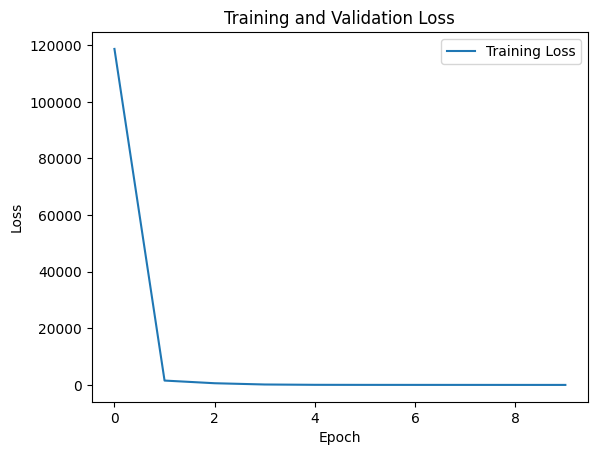

In [ ]:
plt.plot(history_ncf_hr.history['loss'], label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds

# Assume 'df' is your DataFrame containing the data

# Select relevant columns for matrix factorization
data = df[['userId', 'sport', 'duration', 'avg_heart_rate', 'calories', 'distance', 'avg_speed']]

# Encode categorical variables
label_encoders = {}
categorical_cols = ['userId', 'sport']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    data.loc[:, col] = label_encoders[col].fit_transform(data.loc[:, col])

# Create user-item matrix
user_item_matrix = pd.pivot_table(data, values=['duration', 'avg_heart_rate', 'calories', 'distance', 'avg_speed'],
                                  index='userId', columns='sport', fill_value=0)

# Convert to sparse matrix
sparse_matrix = coo_matrix(user_item_matrix)

# Perform Singular Value Decomposition (SVD)
U, Sigma, VT = svds(sparse_matrix, k=8)

# Reconstruct the original matrix
predicted_ratings = np.dot(np.dot(U, np.diag(Sigma)), VT)

# Flatten the predicted ratings matrix
X_factorization = predicted_ratings.flatten()

# Create target labels (1 for rated, 0 for unrated)
y_factorization = np.where(X_factorization > 0, 1, 0)

# Split the data into training and testing sets for matrix factorization features
X_train_factorization, X_test_factorization, y_train_factorization, y_test_factorization = train_test_split(
    X_factorization.reshape(-1, 1), y_factorization, test_size=0.2, random_state=42)

# Select relevant columns for MLP model with other features
X_other = data[['duration', 'avg_heart_rate', 'calories']].values
y_speed_sequence = data['avg_speed'].values

# Split the data into training and testing sets for other features
X_train_other, X_test_other, y_train_speed_sequence, y_test_speed_sequence = train_test_split(
    X_other, y_speed_sequence, test_size=0.2, random_state=42)  # Use the same test size as matrix factorization

# Build the input layers
input_factorization = Input(shape=(1,))
input_other = Input(shape=(X_train_other.shape[1],))

# Combine the input layers
combined_input = Concatenate(axis=1)([input_factorization, input_other])

# Add hidden layers for speed prediction
hidden_speed = Dense(64, activation='relu')(combined_input)
hidden_speed = Dense(32, activation='relu')(hidden_speed)

# Create the output layer for speed prediction
output_speed = Dense(1, name='speed')(hidden_speed)

# Create the model for speed prediction
model_speed = Model(inputs=[input_factorization, input_other], outputs=output_speed)
model_speed.compile(optimizer=Adam(), loss='mse')

# Ensure that both X_train_factorization and X_train_other have the same length
train_length_speed = min(len(X_train_factorization), len(X_train_other))
X_train_factorization_speed = X_train_factorization[:train_length_speed]
X_train_other_speed = X_train_other[:train_length_speed]

# Train the model for speed prediction
history_ncf=model_speed.fit([X_train_factorization_speed, X_train_other_speed], y_train_speed_sequence[:train_length_speed],
             epochs=3, batch_size=32, verbose=1)

# Calculate the number of samples in the test set for speed prediction
test_length_speed = min(len(X_test_factorization), len(X_test_other))

# Ensure that both X_test_factorization and X_test_other have the same length
X_test_factorization_speed = X_test_factorization[:test_length_speed]
X_test_other_speed = X_test_other[:test_length_speed]

# Evaluate the model for speed prediction
loss_speed = model_speed.evaluate([X_test_factorization_speed, X_test_other_speed], y_test_speed_sequence[:test_length_speed], verbose=1)
print(f'Test Loss (Speed): {loss_speed}')

# Now, to predict speed sequence using the trained model:

# Predict speed sequence
predicted_speed_sequence = model_speed.predict([X_test_factorization_speed, X_test_other_speed])

# Print or further utilize the predicted speed sequence
print(predicted_speed_sequence)


Epoch 1/3
351/351 [==============================] - 3s 3ms/step - loss: 7469.6997
Epoch 2/3
351/351 [==============================] - 1s 3ms/step - loss: 118.6150
Epoch 3/3
88/88 [==============================] - 0s 1ms/step - loss: 89.5410
Test Loss (Speed): 89.54103088378906
88/88 [==============================] - 0s 1ms/step
[[14.676372 ]
 [17.789669 ]
 [19.182835 ]
 ...
 [ 9.376933 ]
 [16.108227 ]
 [14.9279585]]


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Evaluate the model for speed prediction
loss_speed = model_speed.evaluate([X_test_factorization_speed, X_test_other_speed], y_test_speed_sequence[:test_length_speed], verbose=1)
print(f'Test Loss (Speed): {loss_speed}')

# Calculate R2 score
r2 = r2_score(y_test_speed_sequence[:test_length_speed], predicted_speed_sequence)
print(f'R2 Score: {r2}')

# Calculate MSE
mse = mean_squared_error(y_test_speed_sequence[:test_length_speed], predicted_speed_sequence)
print(f'Mean Squared Error: {mse}')

88/88 [==============================] - 0s 1ms/step - loss: 89.5410
Test Loss (Speed): 89.54103088378906
R2 Score: -0.35135441814028234
Mean Squared Error: 89.54104865193767


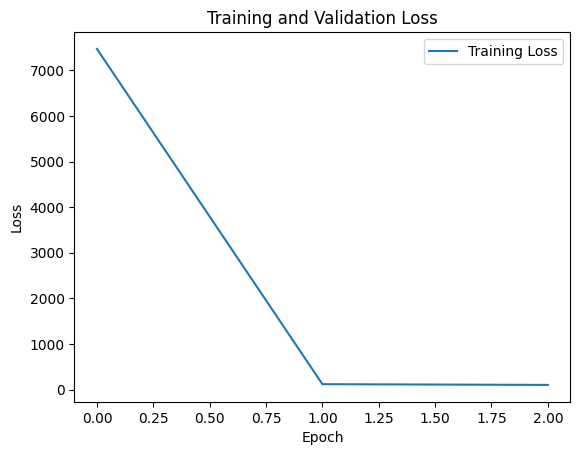

In [ ]:
plt.plot(history_ncf.history['loss'], label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

gru


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam

# ... (same data preprocessing steps as before)

# Separate features for GRU and target variable
X_gru = data[['userId', 'sport']].values
y_speed_sequence = data['avg_speed'].values

# Encode categorical features using one-hot encoding
label_encoder = LabelEncoder()
X_gru[:, 0] = label_encoder.fit_transform(X_gru[:, 0])  # Encode userId
# One-hot encode sport (assuming a limited number of sports)
num_sports = len(set(data['sport']))
X_gru = keras.utils.to_categorical(X_gru[:, 1], num_sports)  # Encode sport

# Split the data into training and testing sets
X_train_gru, X_test_gru, y_train_speed_sequence, y_test_speed_sequence = train_test_split(
    X_gru, y_speed_sequence, test_size=0.2, random_state=42)

# Define the GRU model for speed prediction
max_len = X_train_gru.shape[1]  # Maximum sequence length
embedding_dim = 8  # Embedding dimension for categorical features

input_gru = Input(shape=(max_len,))

# Embedding layer for categorical features (userId and sport)
embedded_gru = Embedding(num_sports + 1, embedding_dim)(input_gru)  # +1 for padding

# GRU layer
gru_layer = GRU(units=32, return_sequences=True)(embedded_gru)

# Concatenate with other features (optional, if available)
# ... (concatenate with other features here if needed)

# Output layer for speed prediction
output_speed = Dense(1, name='speed')(gru_layer)

# Create the GRU model
model_speed_gru = Model(inputs=input_gru, outputs=output_speed)
model_speed_gru.compile(optimizer=Adam(), loss='mse')

# Train the GRU model
history=model_speed_gru.fit(X_train_gru, y_train_speed_sequence, epochs=2, batch_size=32, verbose=1)

# Evaluate the model
loss_speed = model_speed_gru.evaluate(X_test_gru, y_test_speed_sequence, verbose=1)
print(f'Test Loss (Speed - GRU): {loss_speed}')

# Predict speed sequence using the trained GRU model
predicted_speed_sequence = model_speed_gru.predict(X_test_gru)

# Print or further utilize the predicted speed sequence
print(predicted_speed_sequence)


Epoch 1/2
1638/1638 [==============================] - 10s 4ms/step - loss: 0.0383
Epoch 2/2
410/410 [==============================] - 1s 2ms/step - loss: 0.0382
Test Loss (Speed - GRU): 0.038220930844545364
410/410 [==============================] - 1s 2ms/step
[[[0.3238182 ]
  [0.32586563]
  [0.32699472]]

 [[0.3238182 ]
  [0.32586563]
  [0.32699472]]

 [[0.3127153 ]
  [0.31645375]
  [0.3167805 ]]

 ...

 [[0.3238182 ]
  [0.32586563]
  [0.32699472]]

 [[0.3127153 ]
  [0.31645375]
  [0.3167805 ]]

 [[0.3238182 ]
  [0.32586563]
  [0.32699472]]]


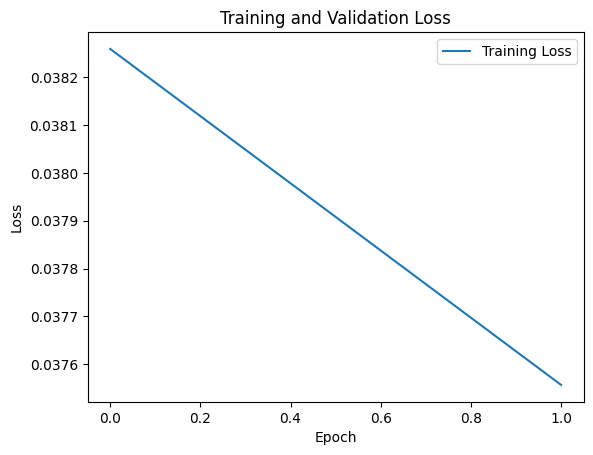

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

from sklearn.metrics import r2_score

# Predict speed sequence
predicted_speed_sequence = model_speed.predict([X_test_factorization_speed, X_test_other_speed])

# Calculate R2 score
r2_speed = r2_score(y_test_speed_sequence[:test_length_speed], predicted_speed_sequence)
print(f'R2 Score (Speed): {r2_speed}')

In [ ]:
mse_hr = mean_squared_error(y_test_hr_sequence[:test_length_hr], predicted_speed_sequence)
print(f'Mean Squared Error (Speed): {mse_hr}')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import Adam

# Assume 'df' is your DataFrame containing the data

# Select relevant columns for heart rate sequence prediction
data = df[['userId', 'sport', 'duration', 'avg_heart_rate', 'calories', 'distance', 'avg_speed']]

# Encode categorical variables
label_encoders = {}
categorical_cols = ['userId', 'sport']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

# Normalize numerical features
scaler = MinMaxScaler()
data[['duration', 'calories', 'distance', 'avg_speed']] = scaler.fit_transform(data[['duration', 'calories', 'distance', 'avg_speed']])

# Sort data by user ID and then by time (assuming there's a time column)
data.sort_values(by=['userId','avg_heart_rate' ],inplace=True)

# Define sequence length (number of time steps to consider)
sequence_length = 10  # You can adjust this value based on your data and requirements

# Prepare sequences for each user
sequences = []
next_hr_values = []
for user_id, user_data in data.groupby('userId'):
    for i in range(len(user_data) - sequence_length):
        seq = user_data.iloc[i:i+sequence_length][['duration', 'avg_heart_rate', 'calories', 'distance', 'avg_speed']].values
        sequences.append(seq)
        next_hr_values.append(user_data.iloc[i+sequence_length]['avg_heart_rate'])

# Convert sequences and next_hr_values to numpy arrays
sequences = np.array(sequences)
next_hr_values = np.array(next_hr_values)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, next_hr_values, test_size=0.2, random_state=42)

# Define the GRU model
model = Sequential()
model.add(GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))  # Output layer for heart rate prediction

# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history_gru=model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {loss}')

# Now, to predict heart rate sequences using the trained model:

# Predict heart rate sequences
predicted_hr_sequences = model.predict(X_test)

# Print or further utilize the predicted heart rate sequences
print(predicted_hr_sequences)


Epoch 1/10
1433/1433 [==============================] - 16s 9ms/step - loss: 10894.9707
Epoch 2/10
1433/1433 [==============================] - 14s 9ms/step - loss: 2041.2059
Epoch 3/10
1433/1433 [==============================] - 14s 9ms/step - loss: 223.8046
Epoch 4/10
1433/1433 [==============================] - 13s 9ms/step - loss: 37.9090
Epoch 5/10
1433/1433 [==============================] - 14s 10ms/step - loss: 10.7773
Epoch 6/10
1433/1433 [==============================] - 14s 10ms/step - loss: 4.2586
Epoch 7/10
1433/1433 [==============================] - 15s 11ms/step - loss: 2.3164
Epoch 8/10
1433/1433 [==============================] - 14s 10ms/step - loss: 1.6121
Epoch 9/10
1433/1433 [==============================] - 14s 10ms/step - loss: 1.3097
Epoch 10/10
359/359 [==============================] - 2s 3ms/step - loss: 2.1877
Test Loss: 2.187718391418457
359/359 [==============================] - 2s 4ms/step
[[160.07404 ]
 [112.972466]
 [122.32564 ]
 ...
 [135.25824 ]
 

In [ ]:
from sklearn.metrics import r2_score

# Calculate R2 score
r2 = r2_score(y_test, predicted_hr_sequences)
print(f'R2 Score: {r2}')


R2 Score: 0.9934112673641695


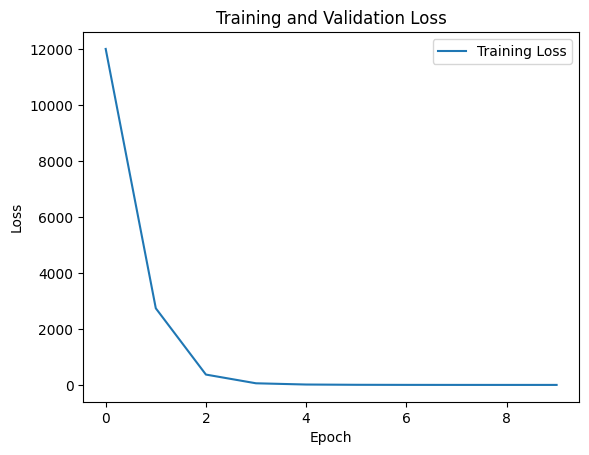

In [ ]:
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()